In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork

from args import *
from utils import *

No module named 'phonopy'
No module named 'phonopy'


In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

In [3]:
type(train_dataset[0].x)

torch.Tensor

In [4]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
model = GCNNetwork(in_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-8)

25092 8364 8363


In [ ]:
epochs = args["epochs"]

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Epoch 1, training loss(MAE)=0.0681, validating loss(MAE)=0.0536, testing loss(MAE)=0.0542, lr=0.01


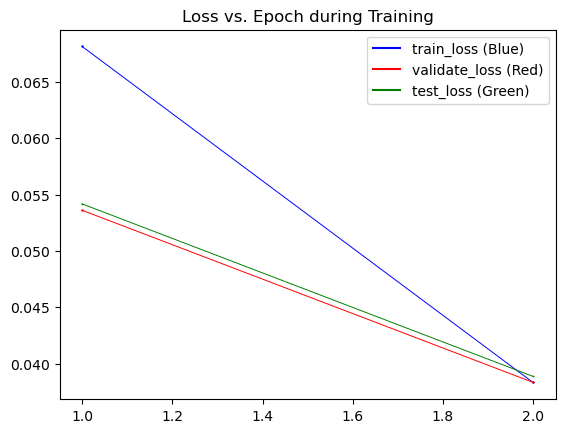

Epoch 2, training loss(MAE)=0.0383, validating loss(MAE)=0.0383, testing loss(MAE)=0.0389, lr=0.01
Epoch 3, training loss(MAE)=0.0333, validating loss(MAE)=0.0328, testing loss(MAE)=0.0332, lr=0.01


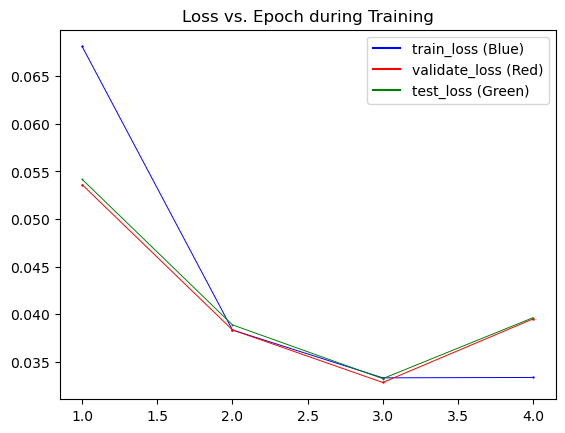

Epoch 4, training loss(MAE)=0.0333, validating loss(MAE)=0.0395, testing loss(MAE)=0.0396, lr=0.01
Epoch 5, training loss(MAE)=0.0326, validating loss(MAE)=0.0341, testing loss(MAE)=0.0344, lr=0.01


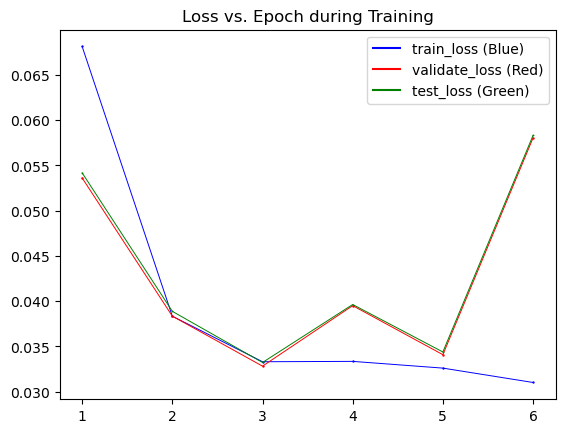

Epoch 6, training loss(MAE)=0.031, validating loss(MAE)=0.058, testing loss(MAE)=0.0583, lr=0.01
Epoch 7, training loss(MAE)=0.033, validating loss(MAE)=0.0288, testing loss(MAE)=0.0295, lr=0.01


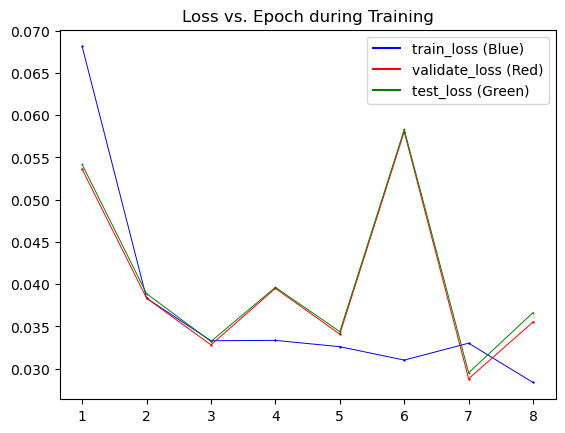

Epoch 8, training loss(MAE)=0.0284, validating loss(MAE)=0.0355, testing loss(MAE)=0.0366, lr=0.01
Epoch 9, training loss(MAE)=0.0299, validating loss(MAE)=0.0277, testing loss(MAE)=0.0283, lr=0.01


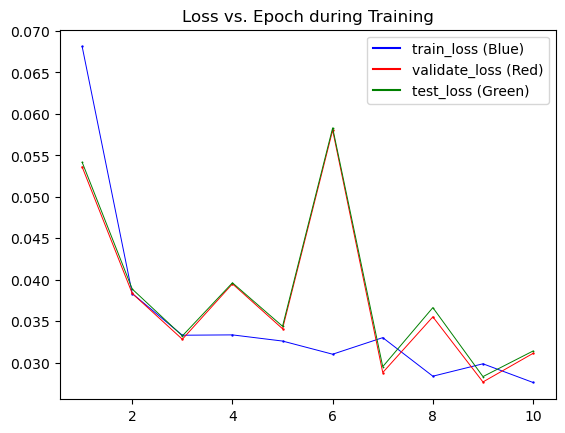

Epoch 10, training loss(MAE)=0.0276, validating loss(MAE)=0.0311, testing loss(MAE)=0.0314, lr=0.01
Epoch 11, training loss(MAE)=0.0275, validating loss(MAE)=0.0259, testing loss(MAE)=0.0266, lr=0.01


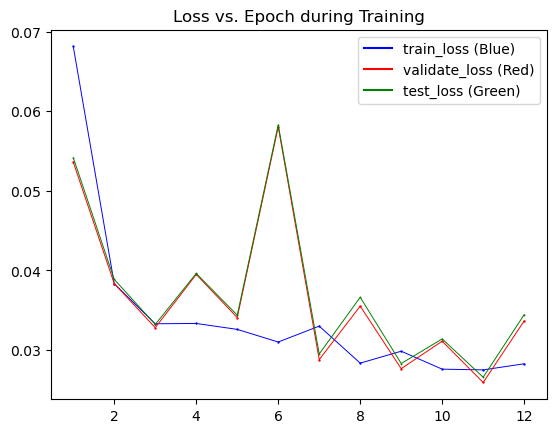

Epoch 12, training loss(MAE)=0.0283, validating loss(MAE)=0.0337, testing loss(MAE)=0.0345, lr=0.01
Epoch 13, training loss(MAE)=0.0285, validating loss(MAE)=0.0247, testing loss(MAE)=0.025, lr=0.01


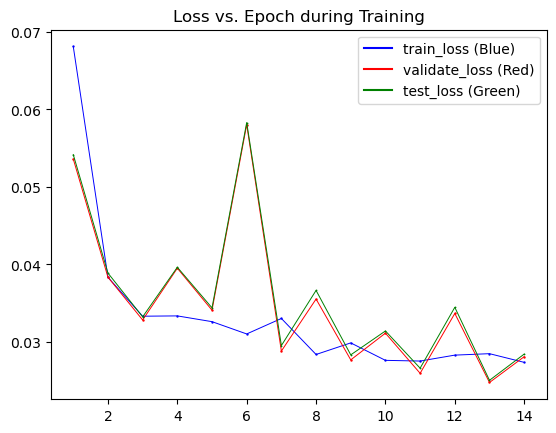

Epoch 14, training loss(MAE)=0.0273, validating loss(MAE)=0.0281, testing loss(MAE)=0.0284, lr=0.01
Epoch 15, training loss(MAE)=0.027, validating loss(MAE)=0.0268, testing loss(MAE)=0.0271, lr=0.01


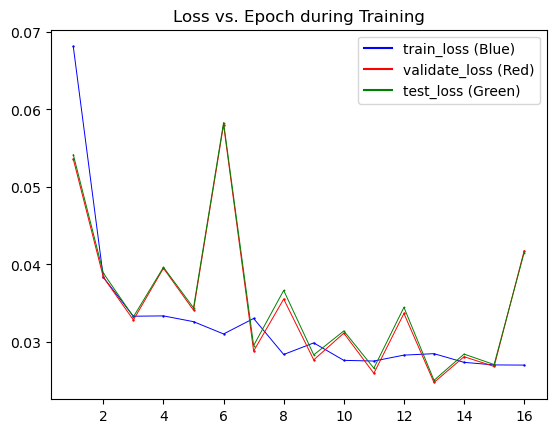

Epoch 16, training loss(MAE)=0.027, validating loss(MAE)=0.0418, testing loss(MAE)=0.0415, lr=0.01
Epoch 17, training loss(MAE)=0.0281, validating loss(MAE)=0.0294, testing loss(MAE)=0.03, lr=0.01


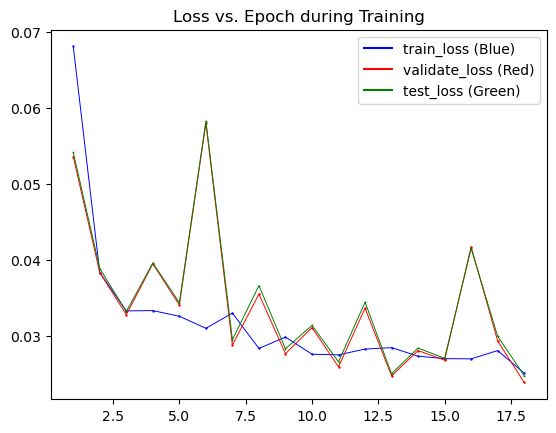

Epoch 18, training loss(MAE)=0.0251, validating loss(MAE)=0.0239, testing loss(MAE)=0.0248, lr=0.01
Epoch 19, training loss(MAE)=0.0263, validating loss(MAE)=0.0242, testing loss(MAE)=0.0245, lr=0.01


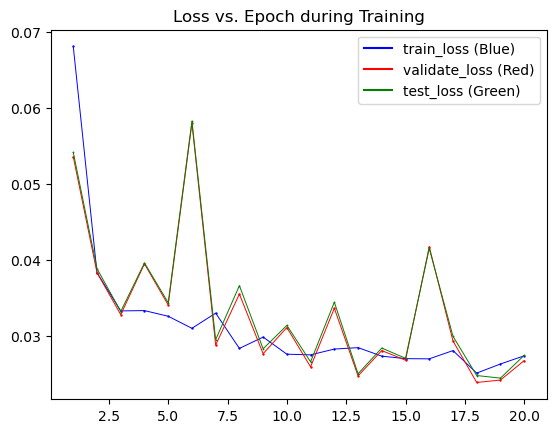

Epoch 20, training loss(MAE)=0.0274, validating loss(MAE)=0.0268, testing loss(MAE)=0.0275, lr=0.01
Epoch 21, training loss(MAE)=0.0283, validating loss(MAE)=0.0265, testing loss(MAE)=0.0269, lr=0.01


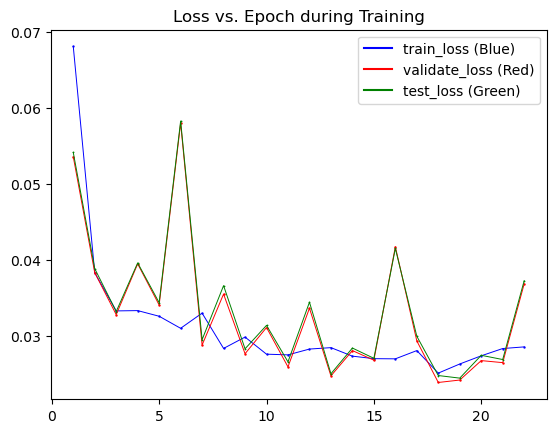

Epoch 22, training loss(MAE)=0.0286, validating loss(MAE)=0.0369, testing loss(MAE)=0.0373, lr=0.01
Epoch 23, training loss(MAE)=0.0282, validating loss(MAE)=0.0295, testing loss(MAE)=0.0303, lr=0.01


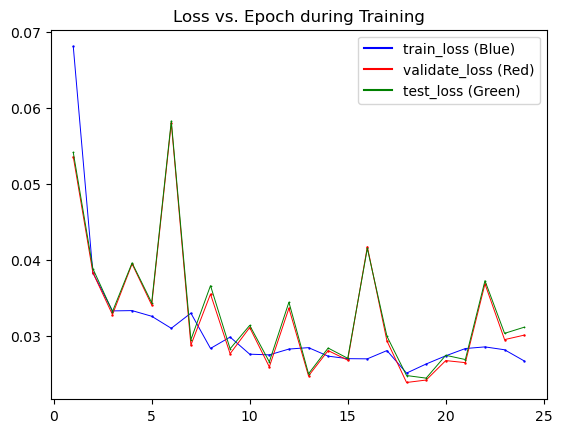

Epoch 24, training loss(MAE)=0.0267, validating loss(MAE)=0.0301, testing loss(MAE)=0.0312, lr=0.01
Epoch 25, training loss(MAE)=0.0256, validating loss(MAE)=0.0239, testing loss(MAE)=0.0239, lr=0.01


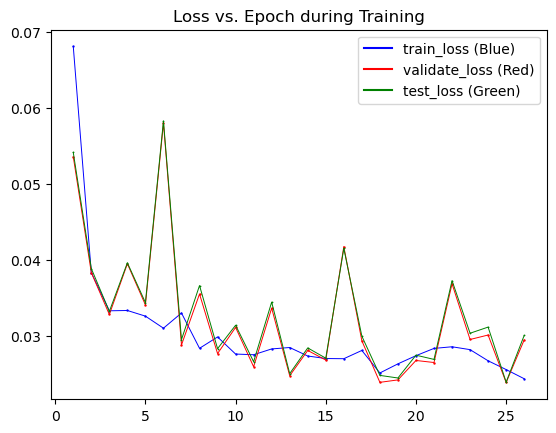

Epoch 26, training loss(MAE)=0.0244, validating loss(MAE)=0.0295, testing loss(MAE)=0.0301, lr=0.01
Epoch 27, training loss(MAE)=0.0241, validating loss(MAE)=0.0274, testing loss(MAE)=0.028, lr=0.01


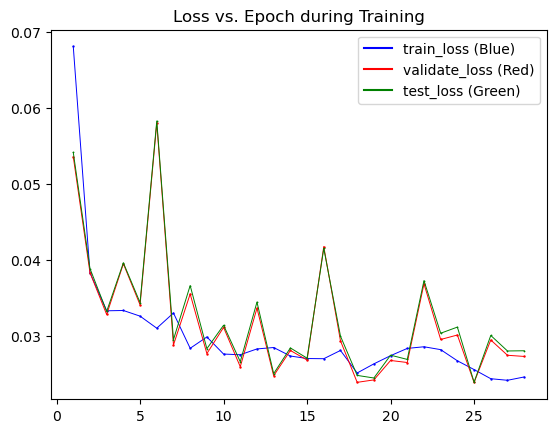

Epoch 28, training loss(MAE)=0.0246, validating loss(MAE)=0.0273, testing loss(MAE)=0.028, lr=0.01
Epoch 29, training loss(MAE)=0.0239, validating loss(MAE)=0.0258, testing loss(MAE)=0.0259, lr=0.01


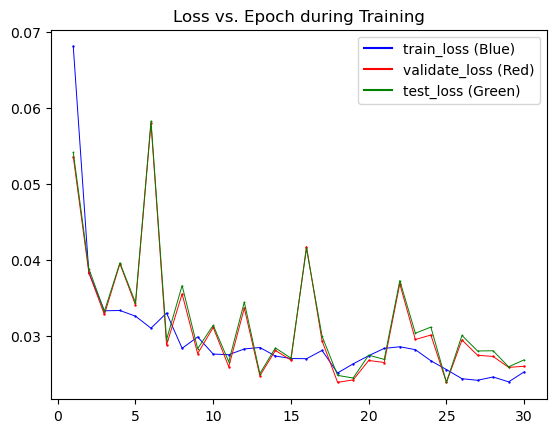

Epoch 30, training loss(MAE)=0.0253, validating loss(MAE)=0.026, testing loss(MAE)=0.0268, lr=0.01
Epoch 31, training loss(MAE)=0.0242, validating loss(MAE)=0.0267, testing loss(MAE)=0.0276, lr=0.01


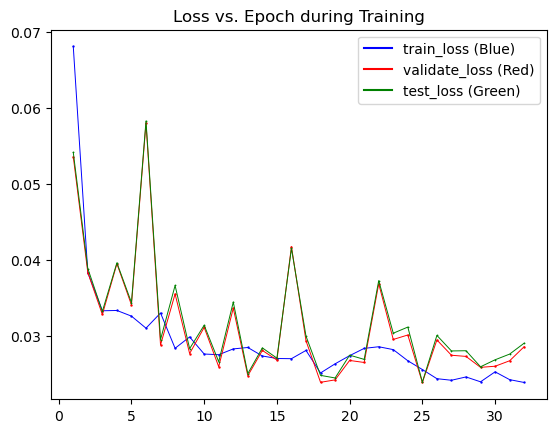

Epoch 32, training loss(MAE)=0.0239, validating loss(MAE)=0.0286, testing loss(MAE)=0.029, lr=0.01
Epoch 33, training loss(MAE)=0.0254, validating loss(MAE)=0.0259, testing loss(MAE)=0.0265, lr=0.01


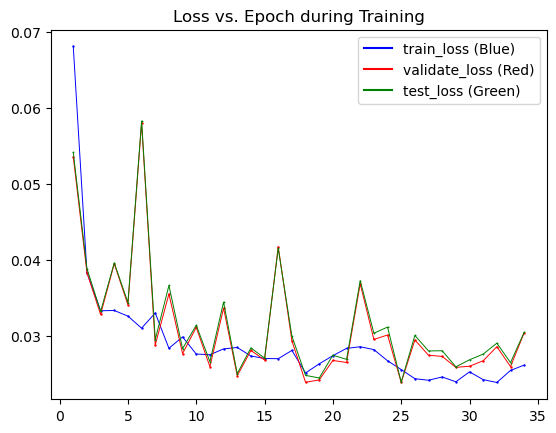

Epoch 34, training loss(MAE)=0.0261, validating loss(MAE)=0.0304, testing loss(MAE)=0.0305, lr=0.01
Epoch 35, training loss(MAE)=0.0281, validating loss(MAE)=0.0224, testing loss(MAE)=0.0227, lr=0.01


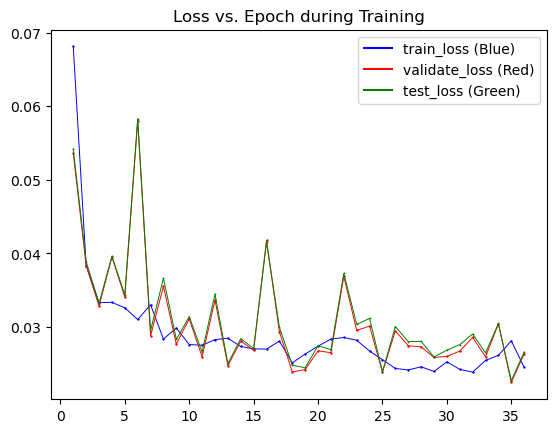

Epoch 36, training loss(MAE)=0.0245, validating loss(MAE)=0.0263, testing loss(MAE)=0.0266, lr=0.01
Epoch 37, training loss(MAE)=0.0239, validating loss(MAE)=0.0215, testing loss(MAE)=0.022, lr=0.01


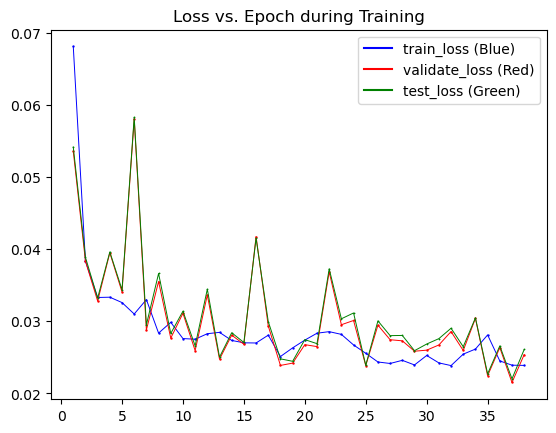

Epoch 38, training loss(MAE)=0.0239, validating loss(MAE)=0.0254, testing loss(MAE)=0.0261, lr=0.01
Epoch 39, training loss(MAE)=0.0234, validating loss(MAE)=0.0276, testing loss(MAE)=0.0279, lr=0.01


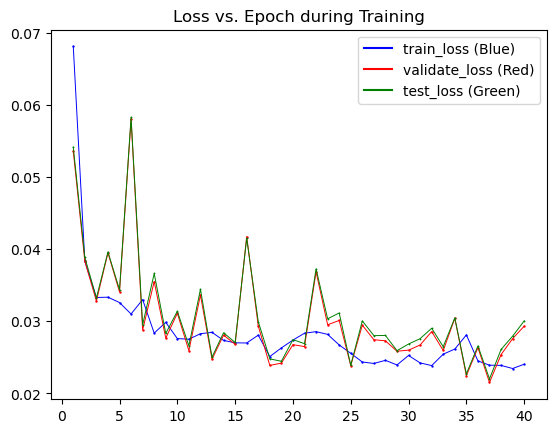

Epoch 40, training loss(MAE)=0.024, validating loss(MAE)=0.0293, testing loss(MAE)=0.0301, lr=0.01
Epoch 41, training loss(MAE)=0.023, validating loss(MAE)=0.0209, testing loss(MAE)=0.0211, lr=0.01


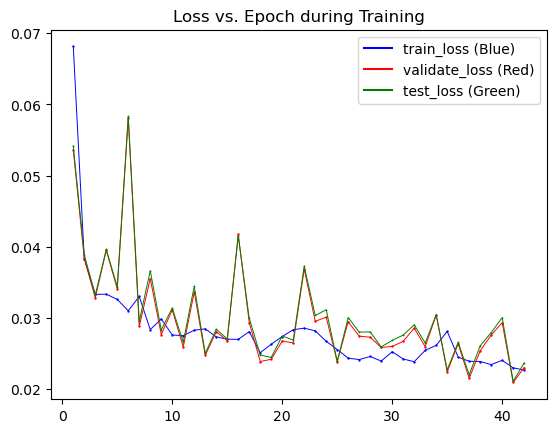

Epoch 42, training loss(MAE)=0.0227, validating loss(MAE)=0.023, testing loss(MAE)=0.0237, lr=0.01
Epoch 43, training loss(MAE)=0.0218, validating loss(MAE)=0.021, testing loss(MAE)=0.0216, lr=0.01


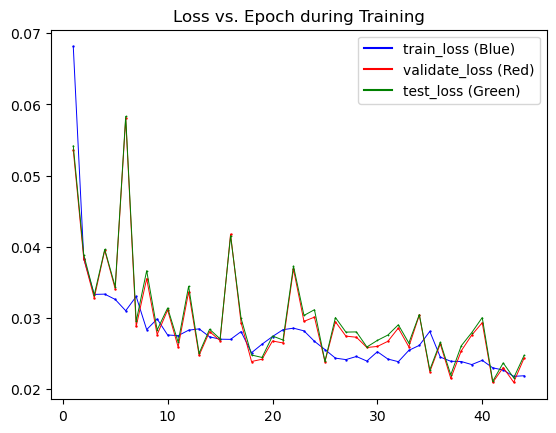

Epoch 44, training loss(MAE)=0.0219, validating loss(MAE)=0.0244, testing loss(MAE)=0.0248, lr=0.01
Epoch 45, training loss(MAE)=0.0217, validating loss(MAE)=0.0202, testing loss(MAE)=0.0205, lr=0.01


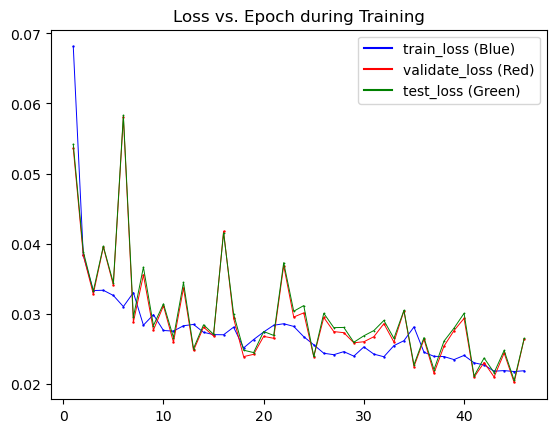

Epoch 46, training loss(MAE)=0.0219, validating loss(MAE)=0.0264, testing loss(MAE)=0.0265, lr=0.01
Epoch 47, training loss(MAE)=0.0231, validating loss(MAE)=0.0228, testing loss(MAE)=0.0229, lr=0.01


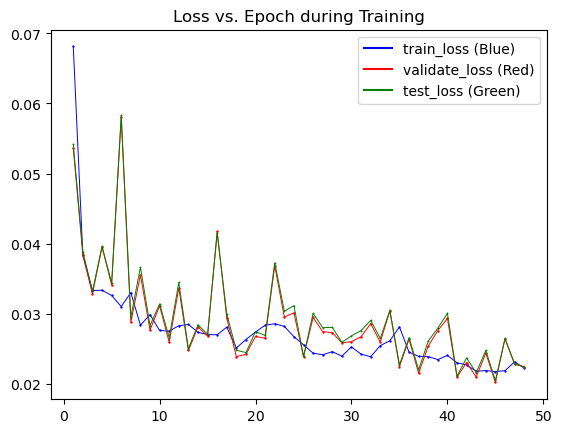

Epoch 48, training loss(MAE)=0.0222, validating loss(MAE)=0.0224, testing loss(MAE)=0.0224, lr=0.01
Epoch 49, training loss(MAE)=0.0228, validating loss(MAE)=0.0249, testing loss(MAE)=0.0251, lr=0.01


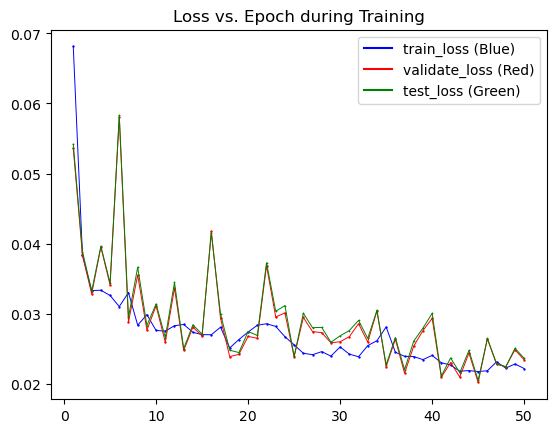

Epoch 50, training loss(MAE)=0.0222, validating loss(MAE)=0.0234, testing loss(MAE)=0.0236, lr=0.01
Epoch 51, training loss(MAE)=0.0233, validating loss(MAE)=0.0206, testing loss(MAE)=0.0208, lr=0.01


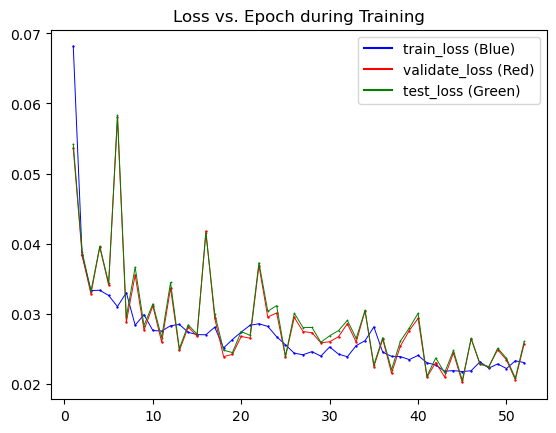

Epoch 52, training loss(MAE)=0.023, validating loss(MAE)=0.0257, testing loss(MAE)=0.026, lr=0.01
Epoch 53, training loss(MAE)=0.0226, validating loss(MAE)=0.023, testing loss(MAE)=0.0229, lr=0.01


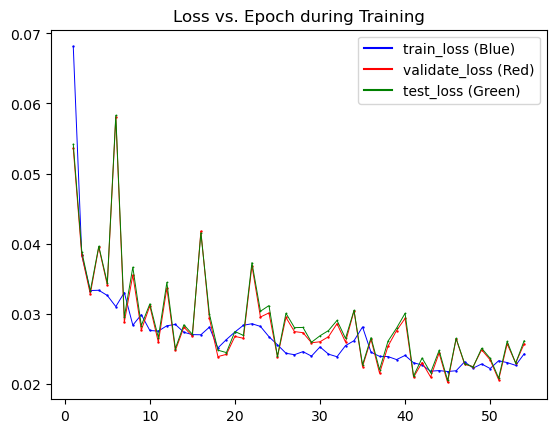

Epoch 54, training loss(MAE)=0.0243, validating loss(MAE)=0.0257, testing loss(MAE)=0.0262, lr=0.01
Epoch 55, training loss(MAE)=0.0229, validating loss(MAE)=0.0238, testing loss(MAE)=0.0239, lr=0.01


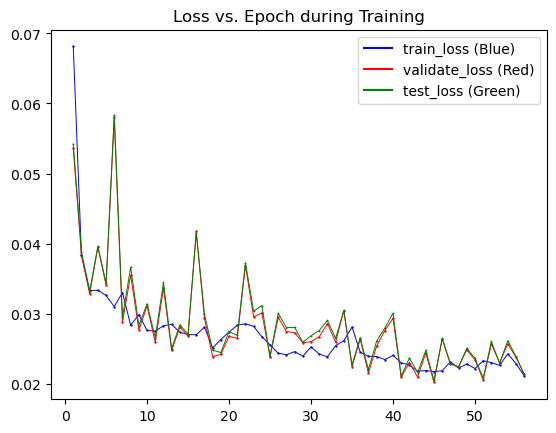

Epoch 56, training loss(MAE)=0.0211, validating loss(MAE)=0.0213, testing loss(MAE)=0.0214, lr=0.008
Epoch 57, training loss(MAE)=0.0209, validating loss(MAE)=0.0233, testing loss(MAE)=0.0239, lr=0.008


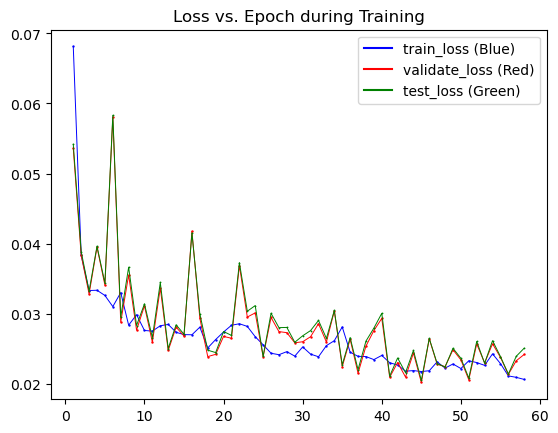

Epoch 58, training loss(MAE)=0.0206, validating loss(MAE)=0.0242, testing loss(MAE)=0.0251, lr=0.008
Epoch 59, training loss(MAE)=0.0198, validating loss(MAE)=0.0219, testing loss(MAE)=0.0224, lr=0.008


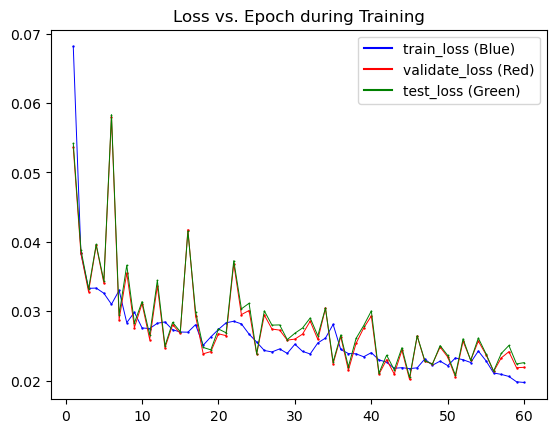

Epoch 60, training loss(MAE)=0.0197, validating loss(MAE)=0.0219, testing loss(MAE)=0.0226, lr=0.008
Epoch 61, training loss(MAE)=0.0195, validating loss(MAE)=0.0206, testing loss(MAE)=0.0213, lr=0.008


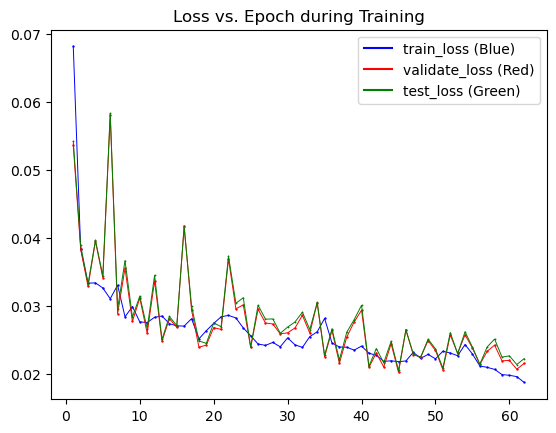

Epoch 62, training loss(MAE)=0.0187, validating loss(MAE)=0.0215, testing loss(MAE)=0.0222, lr=0.008
Epoch 63, training loss(MAE)=0.0189, validating loss(MAE)=0.0221, testing loss(MAE)=0.0231, lr=0.008


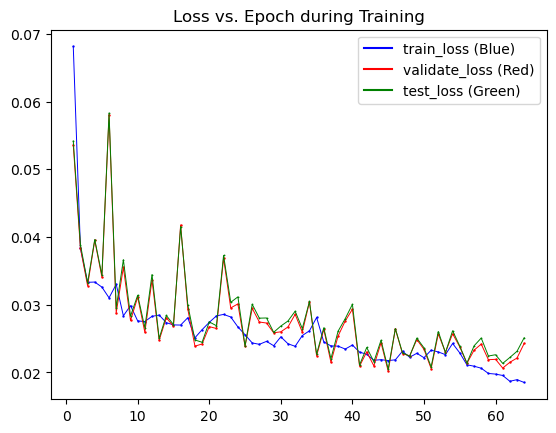

Epoch 64, training loss(MAE)=0.0185, validating loss(MAE)=0.0243, testing loss(MAE)=0.0251, lr=0.008
Epoch 65, training loss(MAE)=0.0198, validating loss(MAE)=0.0328, testing loss(MAE)=0.0338, lr=0.008


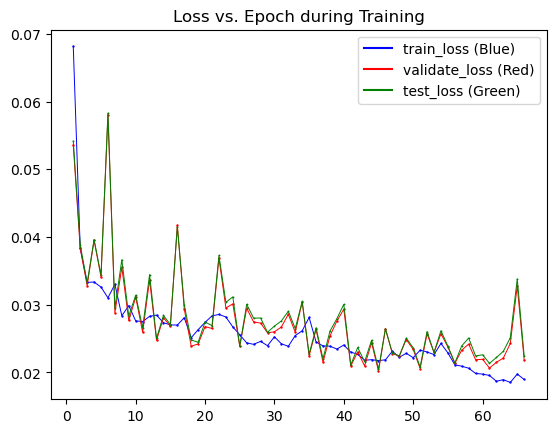

Epoch 66, training loss(MAE)=0.019, validating loss(MAE)=0.0218, testing loss(MAE)=0.0224, lr=0.008
Epoch 67, training loss(MAE)=0.0183, validating loss(MAE)=0.0231, testing loss(MAE)=0.0239, lr=0.0064


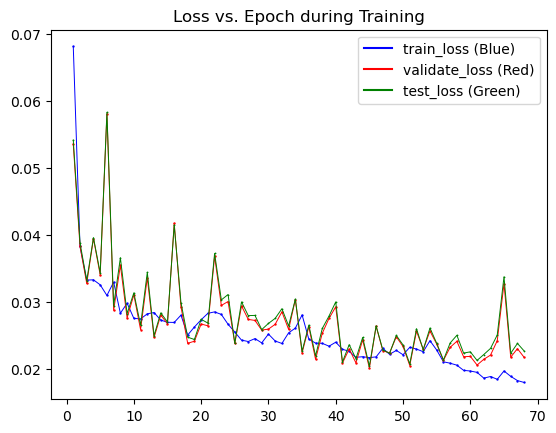

Epoch 68, training loss(MAE)=0.018, validating loss(MAE)=0.0218, testing loss(MAE)=0.0227, lr=0.0064
Epoch 69, training loss(MAE)=0.0174, validating loss(MAE)=0.0243, testing loss(MAE)=0.0249, lr=0.0064


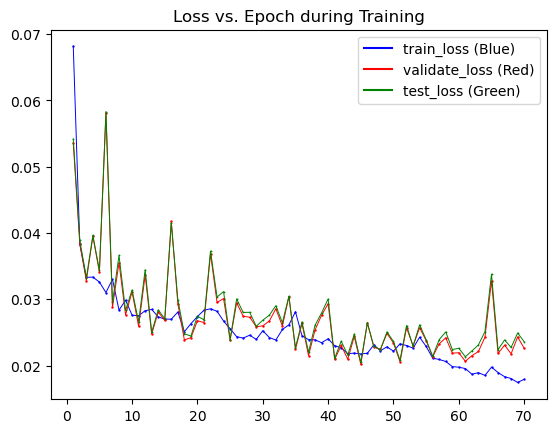

Epoch 70, training loss(MAE)=0.0179, validating loss(MAE)=0.0226, testing loss(MAE)=0.0236, lr=0.0064
Epoch 71, training loss(MAE)=0.0172, validating loss(MAE)=0.0228, testing loss(MAE)=0.0236, lr=0.0064


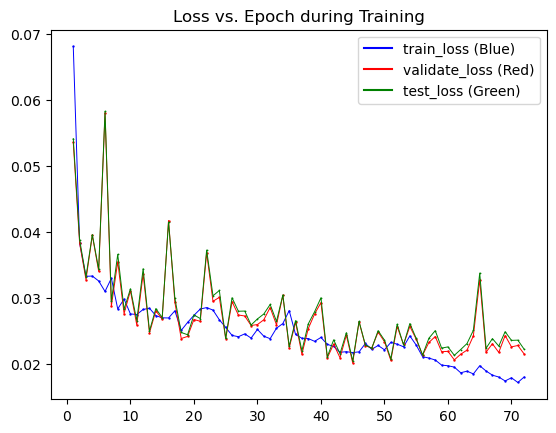

Epoch 72, training loss(MAE)=0.0181, validating loss(MAE)=0.0215, testing loss(MAE)=0.0222, lr=0.0064
Epoch 73, training loss(MAE)=0.0169, validating loss(MAE)=0.0229, testing loss(MAE)=0.0238, lr=0.0064


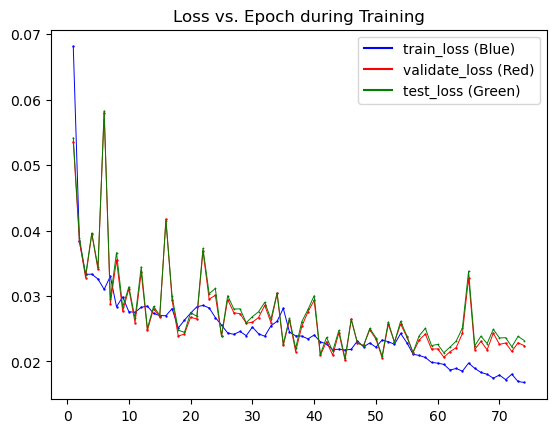

Epoch 74, training loss(MAE)=0.0168, validating loss(MAE)=0.0224, testing loss(MAE)=0.0232, lr=0.0064
Epoch 75, training loss(MAE)=0.0184, validating loss(MAE)=0.0264, testing loss(MAE)=0.0274, lr=0.0064


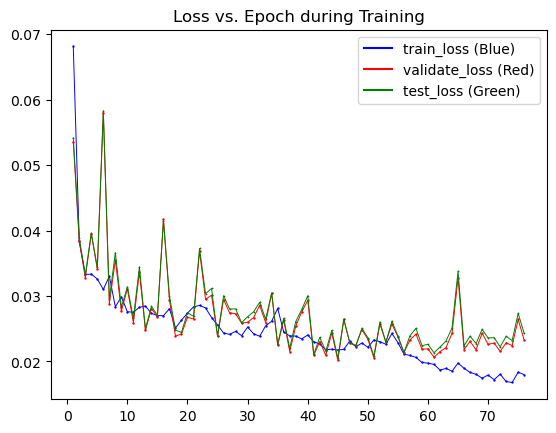

Epoch 76, training loss(MAE)=0.018, validating loss(MAE)=0.0233, testing loss(MAE)=0.0243, lr=0.0064
Epoch 77, training loss(MAE)=0.0175, validating loss(MAE)=0.0215, testing loss(MAE)=0.0222, lr=0.0064


KeyboardInterrupt: 

In [6]:
epochs = 1000

for epoch in range(1, epochs + 1):

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    progress_msg = "Epoch " + str(epoch)
    progress_msg += ", training loss(MAE)=" + str(round(train_loss, 4))
    progress_msg += ", validating loss(MAE)=" + str(round(val_loss, 4))
    progress_msg += ", testing loss(MAE)=" + str(round(test_loss, 4))
    progress_msg += ", lr=" + str(round(current_lr, 8))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=2)
    print(progress_msg)

MAE loss of formation energy is:  0.22924330830574036
ok


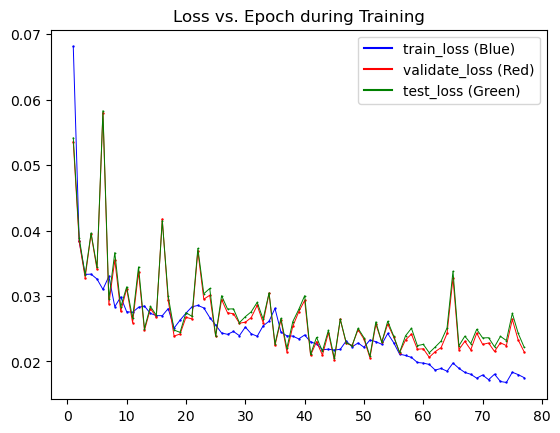

MAE=  2.2366573798711604


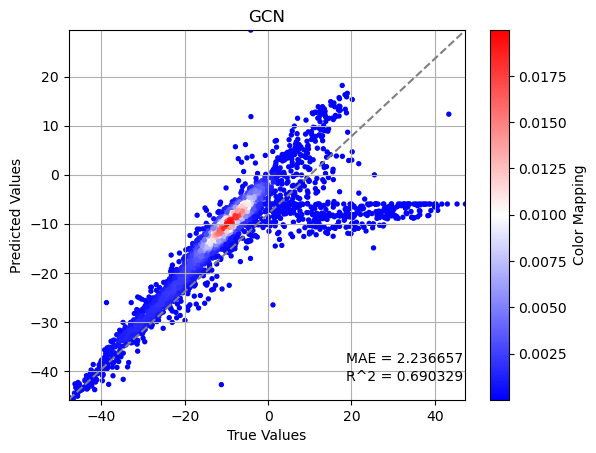

In [22]:
result_path = createResultFolder()
save_hyper_parameter(args, result_path)
save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

# Reverse normalization of test_out and y
min, max = get_data_scale(args)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print("MAE loss of formation energy is: ", loss.item())

# save results
plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path)
save_regression_result(test_out, test_y, result_path)
plot_regression_result("GCN", result_path, plotfilename="regression_figure.jpeg")

In [19]:
# Plot the training progress
def plot_training_progress(
    epoch,
    train_losses,
    val_losses,
    test_losses,
    split=5,
    title="Loss vs. Epoch during Training",
    res_path=None,
    filename="train_progress.jpeg",
):
    if epoch % split != 0 and res_path is None:
        return

    lw = 0.7  # linewidth
    ms = 0.7  # markersize

    threshold = 1
    for i in range(len(train_losses)):
        if train_losses[i] > threshold:
            train_losses[i] = threshold
        if val_losses[i] > threshold:
            val_losses[i] = threshold
        if test_losses[i] > threshold:
            test_losses[i] = threshold

    plt.plot(range(1, epoch + 1, 1), train_losses, marker="o", linestyle="-", color="b", lw=lw, ms=ms)
    plt.plot(range(1, epoch + 1, 1), val_losses, marker="s", linestyle="-", color="r", lw=lw, ms=ms)
    plt.plot(range(1, epoch + 1, 1), test_losses, marker="*", linestyle="-", color="g", lw=lw, ms=ms)

    legend_entries = [
        Line2D([0], [0], color="blue", label="train_loss (Blue)"),
        Line2D([0], [0], color="red", label="validate_loss (Red)"),
        Line2D([0], [0], color="green", label="test_loss (Green)"),
    ]
    plt.title(title)

    plt.legend(handles=legend_entries, loc="upper right")
   
    # save the train graph
    if res_path is not None:
        print("ok")
        filename = osp.join(res_path, filename)
        plt.savefig(filename)

    plt.pause(0.001)

ok


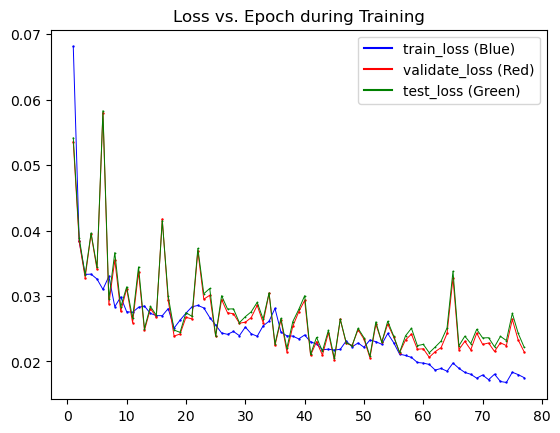